In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
os.chdir('drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned')
path = os.getcwd()
dir_list = os.listdir(path) 
print("Files and directories in '", path, "' :")  
dir_list.sort()
print(dir_list)

Files and directories in ' /content/drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned ' :
['AAPL.pkl', 'AXP.pkl', 'BA.pkl', 'CAT.pkl', 'CSCO.pkl', 'CVX.pkl', 'DIS.pkl', 'GE.pkl', 'GS.pkl', 'HD.pkl', 'IBM.pkl', 'INTC.pkl', 'JNJ.pkl', 'JPM.pkl', 'KO.pkl', 'MCD.pkl', 'MMM.pkl', 'MRK.pkl', 'MSFT.pkl', 'NKE.pkl', 'PFE.pkl', 'PG.pkl', 'TRV.pkl', 'UNH.pkl', 'UTX.pkl', 'V.pkl', 'VZ.pkl', 'WMT.pkl', 'XOM.pkl']


# Preprocessing

In [165]:
df = pd.read_pickle('AAPL.pkl')
fmt = "%Y-%m-%d %H:%M:%S"
df.index = df.index.strftime(fmt)
df.reset_index(inplace=True)
df['SMA100'] = df['Close'].rolling(window = 100).mean()
df.columns

Index([  'Date', 'Symbol',   'Open',   'High',    'Low',  'Close', 'Volume',
              0,        1,        2,
       ...
             91,       92,       93,       94,       95,       96,       97,
             98,       99, 'SMA100'],
      dtype='object', length=108)

In [166]:
df

,Date,Symbol,Open,High,Low,Close,Volume,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,SMA100
0,2017-03-27 09:45:00,AAPL,139.42,140.00,139.26,139.85,959512,0.343900,0.318100,0.202833,0.451283,0.220767,0.097250,0.201217,0.257700,0.219067,0.165283,0.276617,0.137350,0.172100,0.448267,0.708650,0.226317,0.190483,0.333800,0.120800,0.147483,0.145117,0.193000,0.183167,0.183567,0.184133,0.128600,0.223900,0.128167,0.154233,0.367217,0.180700,0.150333,0.241983,...,0.162550,0.147417,0.219800,0.340000,0.152317,0.207333,0.355950,0.117967,0.236667,0.184200,0.193400,0.158450,0.243783,0.133517,0.087300,0.304683,0.236967,0.241633,0.185433,0.154167,1.147950,0.169517,0.112750,0.218383,0.148167,2.09325,0.207067,0.181917,0.294200,0.157467,0.211750,0.225200,0.352883,0.302250,0.189067,0.273767,0.110617,0.285650,0.181733,NaN
1,2017-03-27 10:00:00,AAPL,139.89,140.00,139.10,139.96,521640,0.000000,0.556000,0.185000,0.314000,0.000000,0.385000,0.230000,1.013000,0.000000,0.264000,0.386000,0.660000,0.000000,0.169000,0.787000,0.213000,0.078000,0.190000,0.390000,0.485000,0.000000,0.519000,0.043000,0.000000,0.199000,0.736000,0.226000,0.277000,0.172000,0.077000,0.232000,0.134000,0.062000,...,0.162000,0.000000,0.617000,0.824000,0.284000,0.000000,0.341000,0.076000,0.379000,0.133000,0.000000,0.000000,0.698000,0.348000,0.101000,0.662000,0.415000,0.347000,0.224000,0.000000,2.211000,0.398000,0.311000,0.421000,0.111000,2.96100,0.000000,0.795000,0.479000,0.000000,0.138000,0.185000,0.771000,0.715000,0.232000,0.382000,0.305000,0.027000,0.085000,NaN
2,2017-03-27 10:15:00,AAPL,140.01,140.28,140.01,140.24,184645,0.480000,0.328000,0.421000,0.174000,0.247000,0.146000,0.166000,0.771000,0.420000,0.165000,0.474000,0.119000,0.001000,1.515000,1.147000,0.432000,0.083000,0.125000,0.567000,0.300000,0.386000,0.667000,0.489000,0.193000,0.316000,0.267000,0.801000,0.064000,0.074000,0.311000,0.237000,0.518000,0.080000,...,0.205000,0.067000,0.077000,0.080000,0.400000,0.408000,0.081000,0.094000,0.318000,0.309000,0.550000,0.243000,0.259000,0.437000,0.193000,0.092000,0.134000,1.061000,0.307000,0.158000,1.275000,0.287000,0.144000,0.242000,0.439000,2.81400,0.164000,0.160000,0.000000,0.049000,0.730000,0.102000,0.794000,0.043000,0.214000,0.583000,0.268000,0.370000,0.374000,NaN
3,2017-03-27 10:30:00,AAPL,140.13,140.42,140.10,140.28,631623,0.241000,0.480000,0.234000,0.065000,0.480000,0.097000,0.383000,0.049000,0.408000,0.352000,0.120000,0.116000,0.046000,0.171000,0.109000,0.225000,0.010000,0.218000,0.136000,0.353000,0.338000,0.426000,0.178000,0.220000,0.274000,0.088000,0.282000,0.064000,0.305000,0.531000,0.206000,0.087000,0.134000,...,0.153000,0.694000,0.290000,0.832000,0.135000,0.060000,0.126000,0.094000,0.148000,0.413000,0.225000,0.095000,0.459000,0.076000,0.128000,0.092000,0.202000,0.155000,0.248000,0.193000,0.415000,0.231000,0.450000,0.398000,0.466000,1.06300,0.150000,0.541000,0.119000,0.125000,0.270000,0.139000,0.152000,0.310000,0.550000,0.221000,0.083000,0.065000,0.121000,NaN
4,2017-03-27 10:45:00,AAPL,140.46,140.50,140.36,140.46,374625,0.412667,0.240333,0.089000,0.202667,0.326000,0.090333,0.307000,0.180333,0.127000,0.054000,0.227000,0.107667,0.043333,0.701667,0.440667,0.129000,0.151667,0.125000,0.144333,0.134000,0.128333,0.188333,0.031333,0.075000,0.105000,0.280667,0.256000,0.064000,0.162667,0.432333,0.171333,0.225000,0.120667,...,0.147000,0.067000,0.115333,0.080000,0.050000,0.094667,0.288333,0.156000,0.101667,0.226667,0.107333,0.095000,0.137667,0.076000,0.131333,0.139000,0.201667,0.081000,0.115000,0.196000,0.598000,0.024000,0.319333,0.237333,0.058000,1.42900,0.096333,0.175333,0.179333,0.149000,0.112000,0.288667,0.276667,0.081000,0.228000,0.056333,0.104333,0.383000,0.177667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Predicting a closing price using DNN


A closing price will be predicted for a deep neural network model and compared with 100-day SMA for their efficiencies.


First, a 100-day window of prices are put together to estimate the next price and the window of prices are adjusted corresponding to prices that one wants to estimate. For every stock, 80% of the prices are trained and the rest will be tested for validating its model performance.

In [0]:
split_time = int(df.shape[0]*.8)
time = df.index.values
series = df['Close'].values
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 300
shuffle_buffer_size = 1000

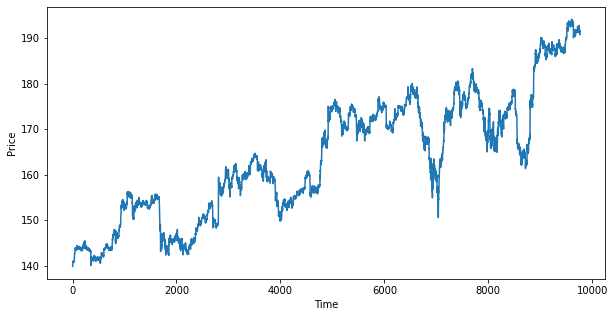

In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(False)


plt.figure(figsize=(10,6))
plot_series(time,series)

A dataset is divided into the train, test test beforehand. A DNN has 3 hidden layers in which there are 100, 50, and 10 neurons for layers respectively and the RELU activation function is used. The wieghts are initialized to avoid vanishing the gradients due to the backpropagation.

### Why Initialize Weights


The aim of weight initialization is to prevent layer activation outputs from exploding or vanishing during the course of a forward pass through a deep neural network. If either occurs, loss gradients will either be too large or too small to flow backwards beneficially, and the network will take longer to converge, if it is even able to do so at all.

When the matrix multiplication, several layers in deep neural nets, the product of this multiplication at one layer becomes the inputs of the subsequent layer, and so on and so forth. Numerous matrix multiplication may lead to vanishing/exploding gradients so one of weights initialization methods is applied(e.g., Xavier's)

In [0]:
tf.random.set_seed(1000)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu", kernel_initializer='glorot_normal'), 
    tf.keras.layers.Dense(50, activation="relu", kernel_initializer='glorot_normal'),
    # tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(dataset, epochs=100)

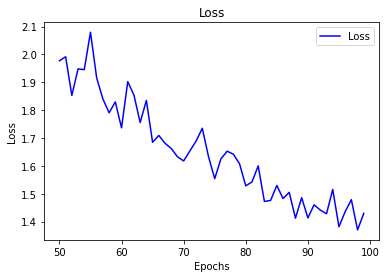

In [45]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[50:], loss[50:], 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

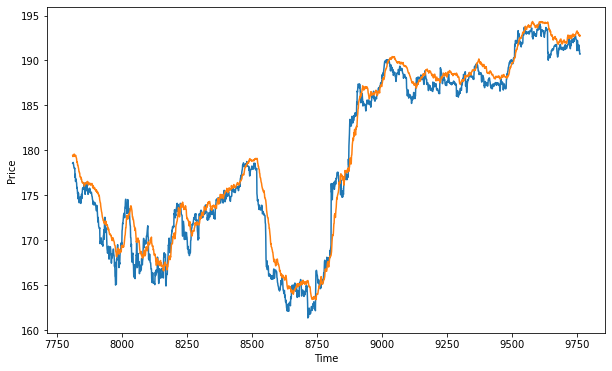

In [46]:
forecast = []
for time in range(len(df) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [49]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

3.0465117

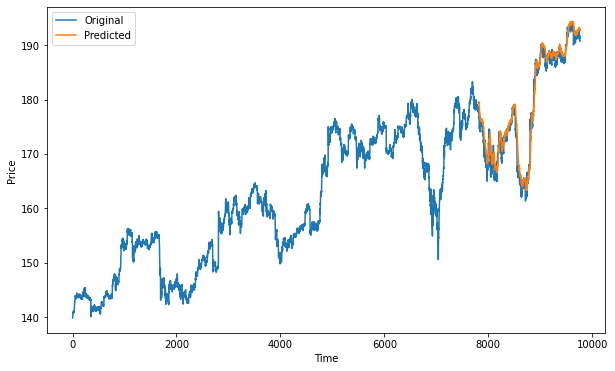

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(series)
plot_series(time_valid, results)
plt.legend(['Original','Predicted'])

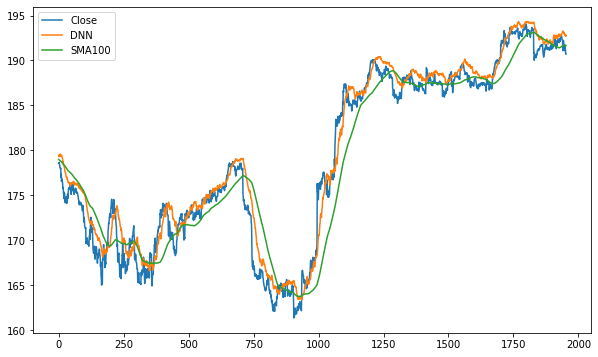

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(x_valid, label = 'Close')
plt.plot(np.array(forecast).reshape(-1), label = 'DNN')
plt.plot(df['SMA100'].values[split_time:], label = 'SMA100')
plt.legend()

## Conclusion

Oviously, the DNN model outperforms the the simple moving average method in predicting closing prices with the mean squred error of 3.046. The price series of DNN looks over-priced than the original overall so further study should be continued to fix this.

# Normalization

In [169]:
xy = np.array(df.iloc[:,2:-1], dtype=np.float32)
scaler = MinMaxScaler()
scaler.fit(xy[:,:5])
xy_pr=scaler.transform(xy[:,:5])
xy = np.concatenate((xy_pr, xy[:,5:]), axis = 1)
print(xy)

[[0.         0.         0.00291538 ... 0.11061667 0.28565    0.18173334]
 [0.00858927 0.         0.         ... 0.305      0.027      0.085     ]
 [0.01078224 0.00516605 0.01658154 ... 0.268      0.37       0.374     ]
 ...
 [0.9448099  0.94557214 0.94515324 ... 0.342      0.489      0.297     ]
 [0.94645476 0.94483423 0.93549585 ... 0.342      0.489      0.297     ]
 [0.9371345  0.95110726 0.94023323 ... 0.16333333 0.8796667  0.269     ]]


In [170]:
# xy = np.array(df.iloc[:,1:], dtype=np.float32)
xy.shape

(9763, 105)

In [0]:
# xy = np.array(
#     [
#         [828.659973, 833.450012, 908100, 828.349976, 831.659973],
#         [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
#         [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
#         [816, 820.958984, 1008100, 815.48999, 819.23999],
#         [819.359985, 823, 1188100, 818.469971, 818.97998],
#         [819, 823, 1198100, 816, 820.450012],
#         [811.700012, 815.25, 1098100, 809.780029, 813.669983],
#         [809.51001, 816.659973, 1398100, 804.539978, 809.559998],
#     ]
# )

# def min_max_scaler(data):
#     numerator = data - np.min(data, 0)
#     denominator = np.max(data, 0) - np.min(data, 0)
#     # noise term prevents the zero division
#     return numerator / (denominator + 1e-7)# * (max-min) + min

# xy = min_max_scaler(xy)
# scaler = MinMaxScaler()
# scaler.fit(xy)
# xy=scaler.transform(xy)
print(xy[:,:5])

# '''
# [[0.99999999 0.99999999 0.         1.         1.        ]
#  [0.70548491 0.70439552 1.         0.71881782 0.83755791]
#  [0.54412549 0.50274824 0.57608696 0.606468   0.6606331 ]
#  [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
#  [0.51436    0.42582389 0.30434783 0.58504805 0.42624401]
#  [0.49556179 0.42582389 0.31521739 0.48131134 0.49276137]
#  [0.11436064 0.         0.20652174 0.22007776 0.18597238]
#  [0.         0.07747099 0.5326087  0.         0.        ]]
# '''

[[8.28659973e+02 8.33450012e+02 9.08100000e+05 8.28349976e+02
  8.31659973e+02]
 [8.23020020e+02 8.28070007e+02 1.82810000e+06 8.21655029e+02
  8.28070007e+02]
 [8.19929993e+02 8.24400024e+02 1.43810000e+06 8.18979980e+02
  8.24159973e+02]
 [8.16000000e+02 8.20958984e+02 1.00810000e+06 8.15489990e+02
  8.19239990e+02]
 [8.19359985e+02 8.23000000e+02 1.18810000e+06 8.18469971e+02
  8.18979980e+02]
 [8.19000000e+02 8.23000000e+02 1.19810000e+06 8.16000000e+02
  8.20450012e+02]
 [8.11700012e+02 8.15250000e+02 1.09810000e+06 8.09780029e+02
  8.13669983e+02]
 [8.09510010e+02 8.16659973e+02 1.39810000e+06 8.04539978e+02
  8.09559998e+02]]


In [171]:
print(int(len(xy) * .9))
print(len(xy))

8786
9763


In [0]:
split_time1 = int(len(xy) * .7)
split_time2 = int(len(xy) * .9)
train_set = xy[:split_time1,:]
valid_set = xy[split_time1:split_time2,:]
test_set = xy[split_time2:,:]


x_train = train_set[:,1:]
y_train = train_set[:,0]
x_val = valid_set[:,1:]
y_val = valid_set[:,0]
x_test = test_set[:,1:]
y_test = test_set[:,0]

y_train = y_train.reshape(-1,1).astype(np.float32)
y_val = y_val.reshape(-1,1).astype(np.float32)
y_test = y_test.reshape(-1,1).astype(np.float32)

In [173]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(6834, 104)
(6834, 1)
(1952, 104)
(1952, 1)
(977, 104)
(977, 1)


In [174]:
x_train

array([[0.        , 0.00291538, 0.        , ..., 0.11061667, 0.28565   ,
        0.18173334],
       [0.        , 0.        , 0.00202823, ..., 0.305     , 0.027     ,
        0.085     ],
       [0.00516605, 0.01658154, 0.00719142, ..., 0.268     , 0.37      ,
        0.374     ],
       ...,
       [0.5182657 , 0.5102043 , 0.51687264, ..., 0.367     , 0.332     ,
        0.128     ],
       [0.52029514, 0.5102043 , 0.50838995, ..., 0.268     , 0.3658    ,
        0.3558    ],
       [0.51107025, 0.5102043 , 0.5045178 , ..., 0.268     , 0.3658    ,
        0.3558    ]], dtype=float32)

# Support Vector Machine


Support vector regression (SVR) is a statistical method that examines the linear relationship between two continuous variables.

In regression problems, we generally try to find a line that best fits the data provided. The equation of the line in its simplest form is described as below y=mx +c. In the case of regression using a support vector machine, we do something similar but with a slight change. Here we define a small error value e (error = prediction - actual).

The value of e determines the width of the error tube (also called insensitive tube). The value of e determines the number of support vectors, and a smaller e value indicates a lower tolerance for error.
Thus, we try to find the line’s best fit in such a way that:
(mx+c)-y ≤ e and y-(mx+c) ≤ e

Also, we do not care about errors as long, as they are less than e. So in this case, only those data points that are outside the e error region will be contributing to the final cost calculation.

For example, if we’re dealing with stock trading, and we want to minimize the trading loss, but we do not care about loss as long as they are less than a certain value (e).

Hence, the support vector regression model depends only on a subset of the training data points, as the cost function of the model ignores any training data close to the model prediction when the error is less than e.

In the realm of machine learning, a support vector regression algorithm can, in some cases, be more suitable for regression problems than other common and popular algorithms. Below are the cases where a support vector regression is advantageous over other regression algorithms:

SVM is memory efficient, which means it takes a relatively lower amount of calculation resources to train the model. This is because presenting the solution by means of a small subset of training points gives enormous computational advantages.

There are non-linear or complex relationships between features and labels. This is because we have the option to convert non-linear relationships to higher-dimensional problems in the case of support vector regression.

In [70]:
df.columns

Index([  'Date', 'Symbol',   'Open',   'High',    'Low',  'Close', 'Volume',
              0,        1,        2,
       ...
             91,       92,       93,       94,       95,       96,       97,
             98,       99, 'SMA100'],
      dtype='object', length=108)

In [0]:
data = np.array(df[df.columns[2:-1]])
y_data = data[:,0]
x_data = data[:,1:4]

y_train = y_data[:split_time]
x_train = x_data[:split_time,:]
y_valid = y_data[split_time:]
x_valid = x_data[split_time:,:]

In [80]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel = 'rbf', C=1e3)
svr_rbf.fit(x_train, y_train)
print(svr_rbf.score(x_train,y_train))

0.9997300024875784


In [82]:
print(np.array(svr_rbf.predict(x_train)))#.reshape(-1,1))
print(y_train.reshape(-1,))

[139.86345194 139.86278986 140.16131897 ... 178.54251067 178.22480942
 178.31554053]
[139.42 139.89 140.01 ... 178.54 178.25 178.42]


In [83]:
tf.keras.metrics.mean_squared_error(y_train.reshape(-1,), np.array(svr_rbf.predict(x_train))).numpy()

0.03608677929457494

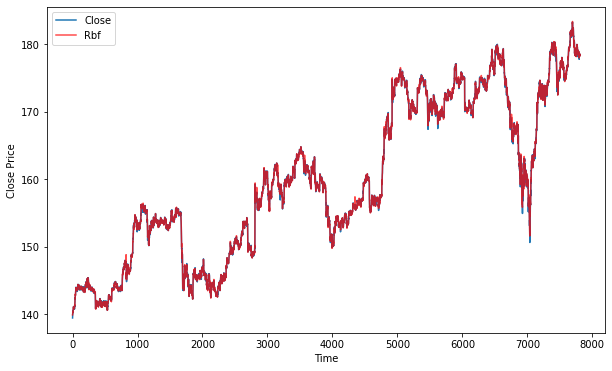

In [108]:
# %matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Close')
plt.plot(svr_rbf.predict(x_train), color='r', label = 'Rbf', alpha = .7)
plt.xlabel('Time')
plt.ylabel('Close Price')
# plt.xlim(9600,9800)
# plt.ylim(180,200)
plt.legend()

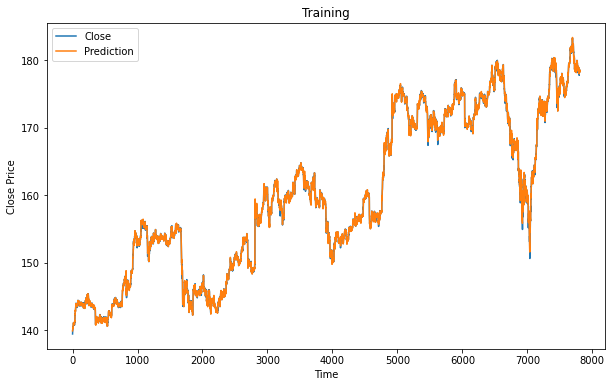

In [104]:
plt.figure(figsize=(10,6))
plt.plot(y_train, label = 'Close')
plt.plot(svr_rbf.predict(x_train), label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Training')
plt.legend()

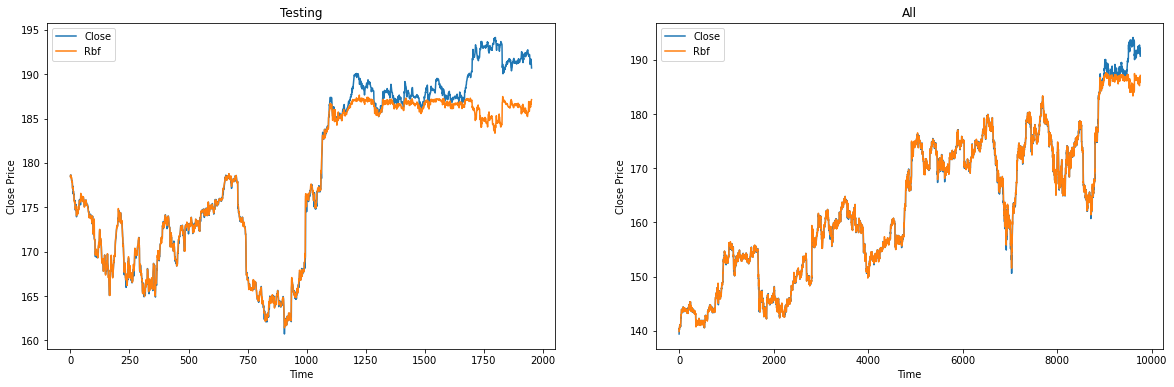

In [107]:
# %matplotlib inline
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(y_valid, label = 'Close')
plt.plot(svr_rbf.predict(x_valid), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Testing')
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_data, label = 'Close')
plt.plot(svr_rbf.predict(x_data), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('All')
plt.legend()



In [111]:
print(svr_rbf.score(x_train,y_train))
print(svr_rbf.score(x_valid,y_valid))

0.9997300024875784
0.9308351408436601


## Insights

Support vector regression gives a better prediction than the DNN with 99% accuracy when training the model, which means that there is a posibility of overfitting the data a bit. This is supported by the prediction accuracy of 93% when testing the model. This shows that the test performance of SVR model seems perfectly fitted until about time 1100 and the errors start getting greater as it goes to the future prediction.

# Neural Network
regularization l2: .01

kernel regularization max-norm: max_value=1

dropout: .5

Ne for first layer: [64, 128, 256]

learning rate: [.001, .0001]

Adam: epsilon=10e-08, beta1=.9, beta2=.999


In [171]:
print(x_train)
print(x_valid)

[[140.   139.26 139.85]
 [140.   139.1  139.96]
 [140.28 140.01 140.24]
 ...
 [178.66 178.54 178.62]
 [178.35 178.19 178.33]
 [178.42 178.39 178.42]]
[[178.58 178.4  178.57]
 [178.74 178.61 178.61]
 [178.65 178.65 178.65]
 ...
 [191.25 190.97 191.21]
 [191.21 190.44 190.71]
 [191.55 190.7  190.71]]


In [172]:
print(y_train.reshape(-1,1))
print(y_valid.reshape(-1,1))

[[139.42]
 [139.89]
 [140.01]
 ...
 [178.54]
 [178.25]
 [178.42]]
[[178.52]
 [178.64]
 [178.65]
 ...
 [191.12]
 [191.21]
 [190.7 ]]


In [0]:
x_scaler = MinMaxScaler()
x_scaler.fit(x_data)
x_data_scaled = x_scaler.transform(x_data)

y_scaler = MinMaxScaler()
y_scaler.fit(y_data.reshape(-1,1))
y_data_scaled = y_scaler.transform(y_data.reshape(-1,1))

y_train_scaled = y_data_scaled[:split_time]
x_train_scaled = x_data_scaled[:split_time,:]
y_valid_scaled = y_data_scaled[split_time:]
x_valid_scaled = x_data_scaled[split_time:,:]

In [174]:
x_data

array([[140.  , 139.26, 139.85],
       [140.  , 139.1 , 139.96],
       [140.28, 140.01, 140.24],
       ...,
       [191.25, 190.97, 191.21],
       [191.21, 190.44, 190.71],
       [191.55, 190.7 , 190.71]])

In [177]:
x_scaler.inverse_transform(x_data_scaled)

array([[140.  , 139.26, 139.85],
       [140.  , 139.1 , 139.96],
       [140.28, 140.01, 140.24],
       ...,
       [191.25, 190.97, 191.21],
       [191.21, 190.44, 190.71],
       [191.55, 190.7 , 190.71]])

In [178]:
# random.seed(777)  # for reproducibility
learning_rate = 0.001
# learning_rate = [0.001, .0001]
l2_reg = .01
max_value = 1
batch_size = 100
training_epochs = 100
# nb_classes = 10
drop_rate = .5
# Ne = [64, 128, 256]
Ne = 128

# smote = SMOTE()
# X_train_smote, Y_train_smote = smote.fit_sample(x_train,y_train)
# X_val_smote, Y_val_smote = smote.fit_sample(x_val,y_val)


# y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
# y_test = tf.keras.utils.to_categorical(y_test, nb_classes)
tf.random.set_seed(1000)
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(Ne, input_shape=(3,), activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(drop_rate),
                             tf.keras.layers.Dense(Ne/2, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(drop_rate),
                             tf.keras.layers.Dense(Ne/4, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(drop_rate),
                             tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')                             
])

model.compile(loss= 'mse',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate))#, epsilon=epsilon),#beta_1=beta1, beta_2=beta2, ),
              # metrics=['accuracy'])
model.summary()

history = model.fit(x_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    verbose = 1,
                    epochs=training_epochs,
                    validation_data=(x_valid_scaled,y_valid_scaled)
                    )

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 128)               512       
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_19 (Batc (None, 64)                256       
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)              

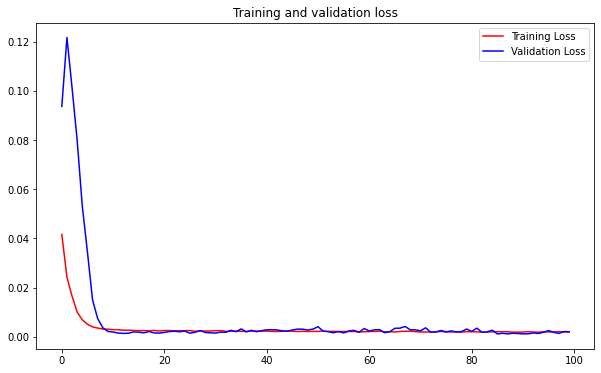

In [179]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

# plt.plot(epochs, acc, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')

# plt.figure()

plt.figure(figsize=(10,6))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

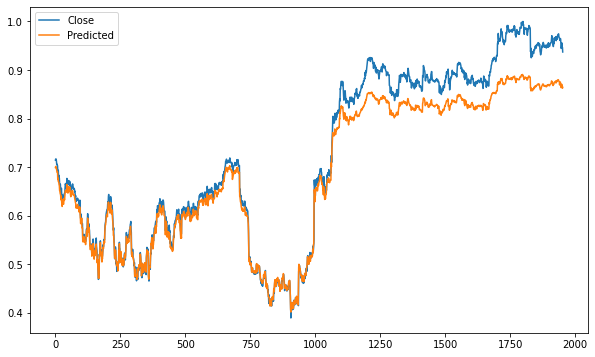

In [181]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_scaled, label = 'Close')
plt.plot(model.predict(x_valid_scaled), label = 'Predicted')
plt.legend()

# Random Forest

# Buy Sell Indicator

In [0]:
def buy_sell(data):
  signal_buy = []
  signal_sell = []
  flag = -1
  for i in range(len(data)):
    if data['SMA30'][i] > data['SMA100'][i]:
      if flag != 1:
        signal_buy.append(data['AAPL'][i])
        signal_sell.append(np.nan)
        flag = 1
      else:
        signal_buy.append(np.nan)
        signal_sell.append(np.nan)
    elif data['SMA30'][i] < data['SMA100'][i]:
      if flag != 0:
        signal_buy.append(np.nan)
        signal_sell.append(data['AAPL'][i])
        flag = 0
      else:
        signal_buy.append(np.nan)
        signal_sell.append(np.nan)
    else:
      signal_buy.append(np.nan)
      signal_sell.append(np.nan)
  
  return signal_buy, signal_sell

buy_sell_data = buy_sell(data)
data['Buy signal'] = buy_sell_data[0]
data['Sell signal'] = buy_sell_data[1]

# Clean Up
Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Reference


https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79